In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display
import IPython.display as ipd

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
mypath = "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [3]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [4]:
p_id_in_file

array([101, 101, 102, 103, 104, 104, 104, 104, 104, 104, 105, 106, 106,
       107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107,
       107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107,
       107, 107, 108, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110,
       110, 111, 111, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113,
       113, 114, 114, 114, 114, 114, 115, 116, 116, 117, 117, 118, 118,
       118, 118, 118, 118, 119, 120, 120, 120, 120, 120, 121, 121, 122,
       122, 122, 122, 122, 122, 122, 122, 122, 123, 124, 124, 124, 124,
       124, 124, 125, 126, 127, 128, 129, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 131, 132, 132, 13

In [5]:
filepaths = [join(mypath, f) for f in filenames]

In [6]:
p_diag = pd.read_csv("Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file
p_diag

,0,1
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [7]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file])
labels

array(['URTI', 'URTI', 'Healthy', 'Asthma', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'URTI', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'LRTI', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Bronchiectasis',
       'Bronchiectasis', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'LRTI', 'Bronchiectasis', 'Bronchiectasis', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'URTI',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'Healthy', 'Healthy',
       'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia',
       'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Healthy',
   

In [8]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [9]:
def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

In [10]:
def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

In [11]:
features = []

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

c:\Users\Vansh Aggarwal\anaconda3\envs\py3-TF2.0\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Finished feature extraction from  929  files


In [14]:
print(features.shape)
new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

(929, 3, 182)


In [18]:
# delete the very rare diseases


new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [17]:
features[0][0].shape

(182,)

In [19]:
new_features.shape

(926, 3, 182)

In [20]:
# print class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '802' '35' '37' '23']]


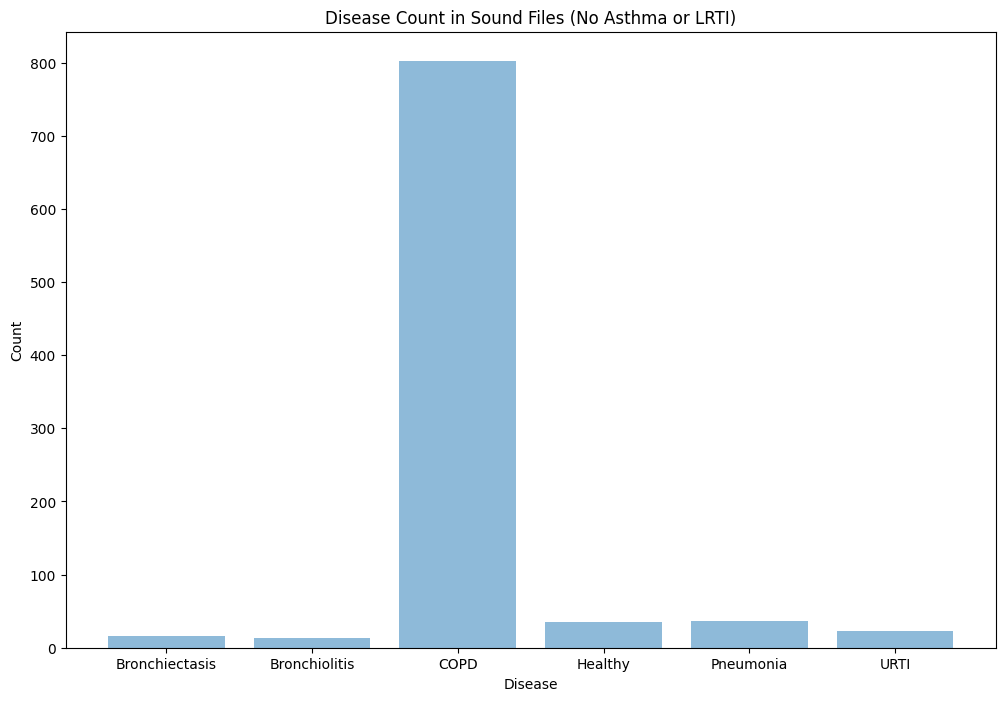

In [21]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [22]:
flattened_features = new_features.reshape(-1, 182)

In [23]:
augmented_labels = np.repeat(labels, 3)

In [24]:
augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets

mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI'])
augmented_features = augmented_features[mask]
augmented_labels = augmented_labels[mask]

In [25]:
le = LabelEncoder()
i_labels = le.fit_transform(augmented_labels)
oh_labels = to_categorical(i_labels)

In [26]:
oh_labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [27]:
flattened_features.shape

(2778, 182)

In [28]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels,
                                                    test_size=0.2, random_state = 42)

In [29]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2222, 182)
(2222, 6)
(556, 182)
(556, 6)


In [30]:
x_train = scaler_data.fit_transform(x_train)
x_test = scaler_data.transform(x_test)
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)


In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2222, 182, 1)
(2222, 6)
(556, 182, 1)
(556, 6)


In [32]:
unique_elements[np.argmax(y_train[0])]

'URTI'

In [33]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

In [34]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
Model.compile(optimizer = optimiser , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
callback=[
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
    ,early_stop
]


In [35]:
evConv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100


35/35 [==============================] - 6s 92ms/step - loss: 1.1296 - accuracy: 0.7813 - val_loss: 0.6794 - val_accuracy: 0.8651
Epoch 2/100
35/35 [==============================] - 3s 80ms/step - loss: 0.7140 - accuracy: 0.8587 - val_loss: 0.6047 - val_accuracy: 0.8651
Epoch 3/100
35/35 [==============================] - 3s 79ms/step - loss: 0.6868 - accuracy: 0.8627 - val_loss: 0.5717 - val_accuracy: 0.8651
Epoch 4/100
35/35 [==============================] - 3s 77ms/step - loss: 0.6546 - accuracy: 0.8623 - val_loss: 0.5488 - val_accuracy: 0.8651
Epoch 5/100
35/35 [==============================] - 3s 90ms/step - loss: 0.6165 - accuracy: 0.8663 - val_loss: 0.5363 - val_accuracy: 0.8651
Epoch 6/100
35/35 [==============================] - 4s 111ms/step - loss: 0.5785 - accuracy: 0.8645 - val_loss: 0.5128 - val_accuracy: 0.8651
Epoch 7/100
35/35 [==============================] - 3s 97ms/step - loss: 0.5759 - accuracy: 0.8650 - val_loss: 0.4955 - val_accuracy: 0.8651
Epo

In [36]:
Model_Results = Model.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

18/18 [==============================] - 0s 17ms/step - loss: 0.3109 - accuracy: 0.9155
LOSS:  0.3109
ACCURACY:  0.9155


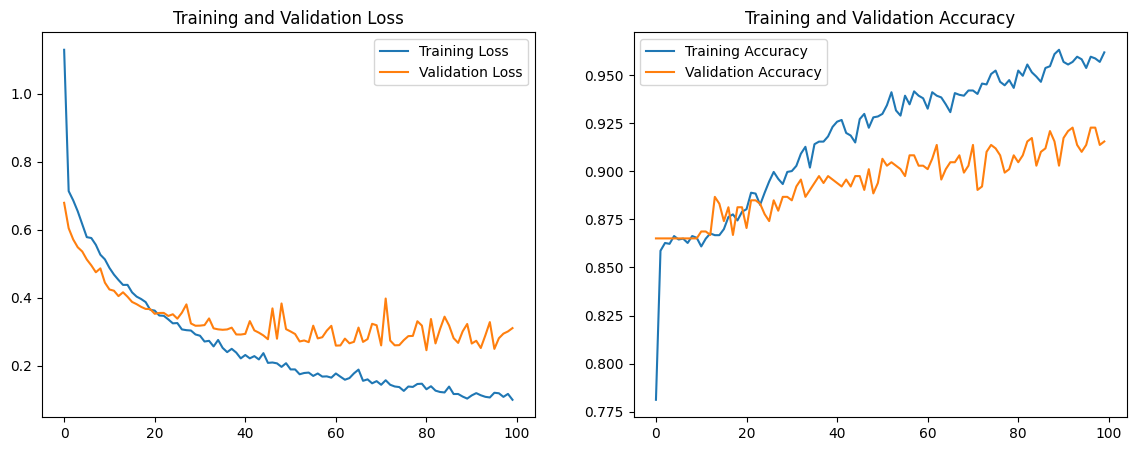

In [37]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

18/18 [==============================] - 1s 16ms/step


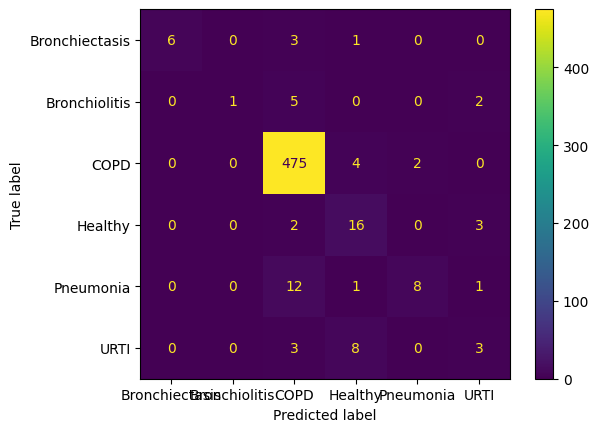

In [38]:
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [39]:
le.classes_

array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
       'URTI'], dtype='<U14')

In [40]:
scaler_data = StandardScaler()

def predict(aud_file):
    feats=[]
    data = extract_features(aud_file)
    
    feats.append(data)
    feats=np.array(feats)
    flattened_features = feats.reshape(-1, 182)
    feat = scaler_data.fit_transform(flattened_features)
    feat = np.expand_dims(feat,axis=2)
    p=Model.predict(feat)
    pred_class = np.argmax(p)
    return unique_elements[pred_class]

In [43]:

files=[audio_file.split('/')[-1]]
a=int(files[0].split('_')[0])
a


120

In [42]:
audio_file='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/120_1b1_Pr_sc_Meditron.wav'

predict(audio_file)


1/1 [==============================] - 0s 38ms/step


'COPD'

In [44]:
from tinymlgen import port
import keras
# reconstructed_model=keras.models.load_model("respiratory.h5")
if __name__ == '__main__':
    tf_model = Model
    c_code = port(tf_model)

    with open('res.h', 'w') as file:
        file.write(c_code)

INFO:tensorflow:Assets written to: C:\Users\VANSHA~1\AppData\Local\Temp\tmp_p3epcp5\assets


INFO:tensorflow:Assets written to: C:\Users\VANSHA~1\AppData\Local\Temp\tmp_p3epcp5\assets


In [45]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(Model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('resp_diagnosis2.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\VANSHA~1\AppData\Local\Temp\tmp_j1ru2yo\assets


INFO:tensorflow:Assets written to: C:\Users\VANSHA~1\AppData\Local\Temp\tmp_j1ru2yo\assets


573392

In [1]:
import keras
reconstructed_model=keras.models.load_model("respiratory.h5")

In [46]:
Model.save("respiratory.h5")

C:\Users\Vansh Aggarwal\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
from tensorflow.keras.utils import plot_model


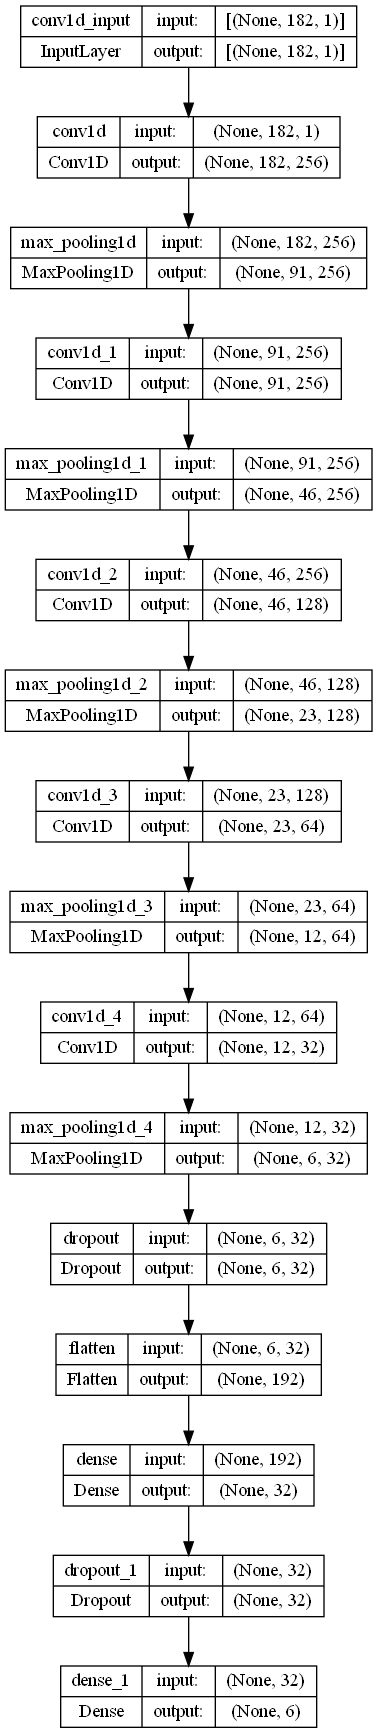

In [49]:
plot_model(Model,to_file='resp_img.png',show_shapes=True)